In [47]:
import pandas as pd
from pprint import pprint
from pathlib import Path
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from collections import defaultdict
import mplhep as hep
import datetime
hep.style.use('CMS')

import warnings
warnings.filterwarnings("ignore")

In [48]:
import os, sys

path2add = os.path.normpath(os.path.abspath(os.path.join(os.path.curdir, os.path.pardir, 'TestBeam')))
print(path2add)

if (not (path2add in sys.path)) :
    sys.path.append(path2add)

from beamtest_analysis_helper import plot_BL_and_NW

/home/daq/ETROC2/ETROC-Analysis/TestBeam


## Load Run Info

In [49]:
base_directory = Path("/media/daq/X9/BelgiumJune2024")
output_dir = base_directory/"AnalysisOutput"
output_dir.mkdir(exist_ok=True)
# runs = [3,4,5,6,9,10,11,13]
runs = ["0010","0011","0012","0013","0014"]
config_compare_dir = output_dir/"I2CConfiguration"
# config_compare_dir = output_dir/f"I2CConfiguration_Run{runs[0]}"
config_compare_dir.mkdir(exist_ok=True)

chip_names = [
    "ET2p01_Bare_7", # Ch0
]

config_directory = Path("/media/daq/X9/BelgiumJune2024/ETROC-Data/BelgiumJune2024/ChipConfig")
list_of_all_files = [f for f in os.listdir(config_directory) if os.path.isfile(os.path.join(config_directory,f))]
# pprint(lisat_of_all_files)
run_info = []
for run in runs:
    start_times = []
    stop_times  = []

    for chip_name in chip_names:

        for f in list_of_all_files: 
            
            list_of_words = f.split('_')
            if(list_of_words[-1].split(".")[0]!=run):continue
            read_chip_name = "_".join(list_of_words[1:4])
            if(read_chip_name!=chip_name): continue
            time_string = list_of_words[0].split("T")
            config_time = datetime.datetime.fromisoformat("T".join([time_string[0],time_string[1].replace("-", ":")]))
            if(list_of_words[4]=="PreRun"):
                start_times += [config_time]
            elif(list_of_words[4]=="PostRun"):
                stop_times+= [config_time]
    run_info += [
        {
            "name": f"Run_{run}",
            "extra_begin": start_times[-1],
            "start": start_times[-1],
            "stop": stop_times[0],
            "boards": chip_names,
            "board_channels": [0],
            "pre_config_times": start_times,
            "post_config_times": stop_times,
            "config_before": True,
            "fluence": 0.0,
        }
    ]

test_run_info =  run_info  
start_time = datetime.datetime(2024, 5, 25, 9, 0, 0)
end_time = datetime.datetime(2024, 5, 25, 23, 0, 0)     

In [51]:
# pprint(run_info)

## Baseline plots

In [52]:
con = sqlite3.connect('/home/daq/ETROC2/ETROC-History/BelgiumJune2024/BaselineHistory.sqlite')

baseline_df = pd.read_sql_query("SELECT * from baselines", con)

baseline_df['timestamp'] = pd.to_datetime(baseline_df['timestamp'], format='%Y-%m-%d %H:%M:%S.%f')
baseline_df['timestamp'] = baseline_df['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')
baseline_df['timestamp'] = pd.to_datetime(baseline_df['timestamp'])

In [53]:
baseline_df.tail()

,col,row,baseline,noise_width,timestamp,chip_name
1795,2,2,367.0,4.0,2024-06-25 13:25:52,ET2p01_Bare_7
1796,8,0,384.0,2.0,2024-06-25 14:37:18,ET2p01_Bare_7
1797,2,0,370.0,3.0,2024-06-25 14:37:19,ET2p01_Bare_7
1798,8,2,374.0,4.0,2024-06-25 14:37:20,ET2p01_Bare_7
1799,2,2,367.0,3.0,2024-06-25 14:37:20,ET2p01_Bare_7


In [54]:
### Add board names in the dictionary

config_dict = {
    'ET2p01_Bare_7': {
        'plot_title': 'ETROC 2.01 Bare Board 7',
        'chip_type': 'T',
        'channel': 0,
    },
}

### Baseline over time

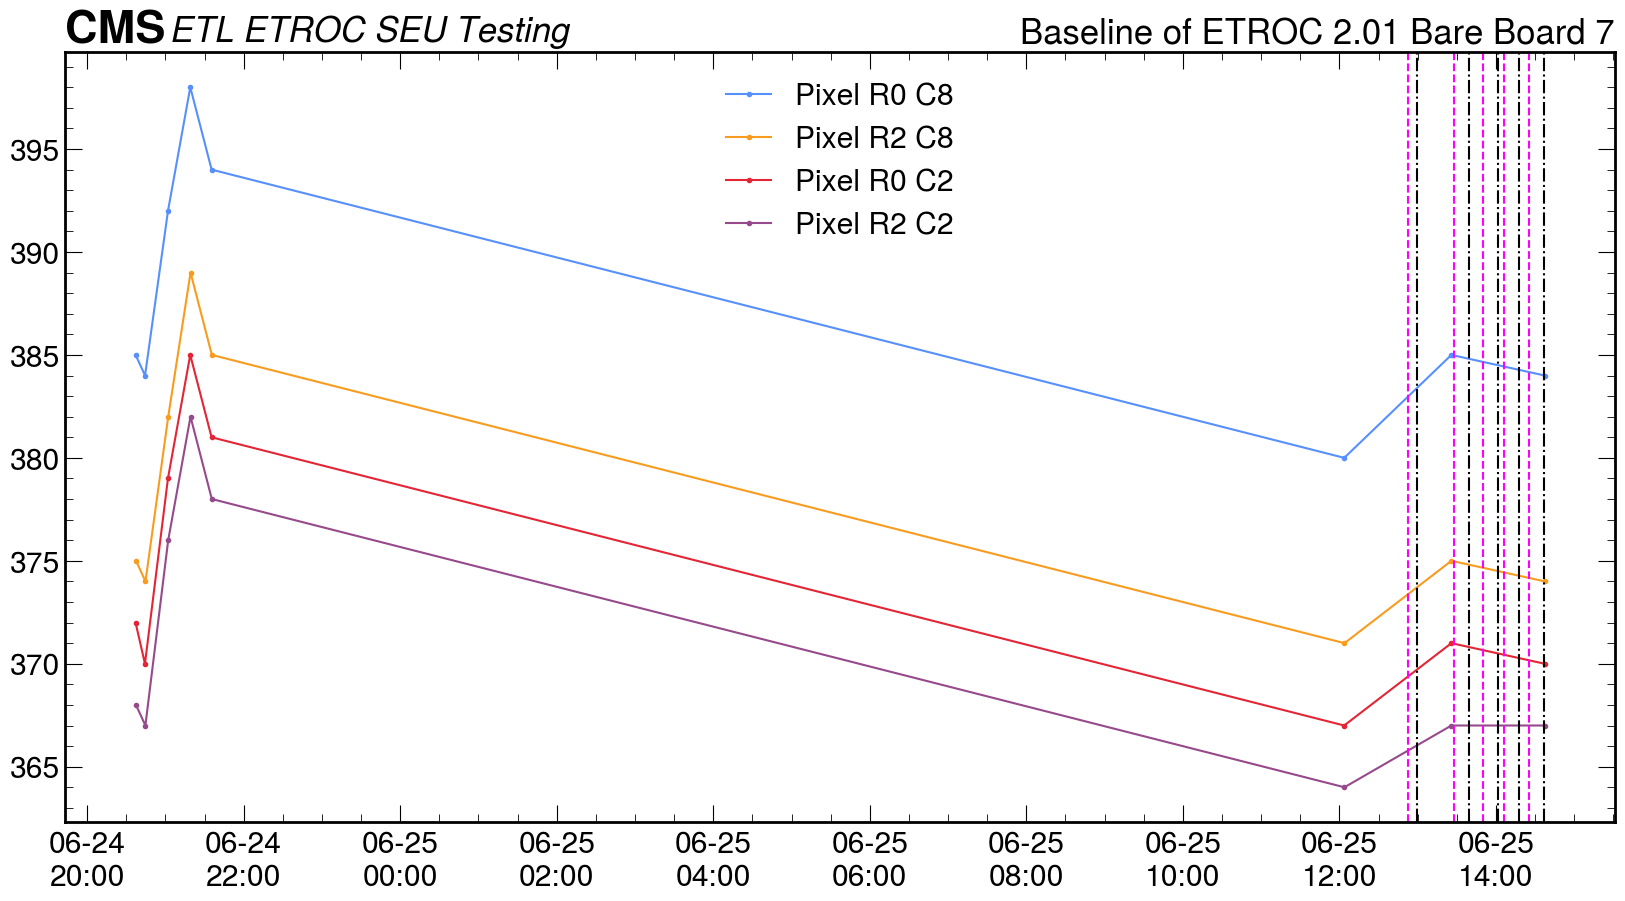

In [55]:
p_col=[8,8,2,2]
p_row=[0,2,0,2]
pixel_plot_list = list(zip(p_row,p_col))

draw_dates = True
cut_time = pd.to_datetime('2024-06-24 20:30:00')

for iboard in baseline_df['chip_name'].unique():
    fig, ax = plt.subplots(figsize=(20, 10))
    hep.cms.text(loc=0, ax=ax, text="ETL ETROC SEU Testing", fontsize=25)
    ax.set_title(f'Baseline of {config_dict[iboard]["plot_title"]}', size=17, loc="right", fontsize=25)
    date_form = mdates.DateFormatter("%m-%d\n%H:%M")
    ax.xaxis.set_major_formatter(date_form)
    for row,col in pixel_plot_list:
        interest_df = baseline_df.loc[baseline_df['chip_name']==iboard]
        tmp_df = interest_df.loc[(interest_df['col']==col) & (interest_df['row']==row)].reset_index(drop=True)
        tmp_df = tmp_df.loc[tmp_df['timestamp'] > cut_time]
        ax.plot(tmp_df['timestamp'], tmp_df['baseline'], label=f'Pixel R{row} C{col}', marker='.')

    if draw_dates:
        for run_dict in run_info:
            if(run_dict['start'] >= cut_time):
                ax.axvline(x=run_dict['start'], color='magenta', linestyle='dashed')
                ax.axvline(x=run_dict['stop'], color='black', linestyle='dashdot')
    # ax.set_xlim(left=cut_time)
    ax.legend()

## Temperature

In [56]:
con = sqlite3.connect('/home/daq/ETROC2/ETROC-History/BelgiumJune2024/ADCHistory.sqlite')

adc_df = pd.read_sql_query("SELECT * from adc", con)

In [57]:
adc_df['timestamp'] = pd.to_datetime(adc_df['timestamp'], format='%Y-%m-%d %H:%M:%S.%f')
adc_df['timestamp'] = adc_df['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')
adc_df['timestamp'] = pd.to_datetime(adc_df['timestamp'])

In [58]:
adc_df.tail()

,timestamp,ADC,channel,voltage,vref,calibrated,calibrated_units
28351,2024-06-25 14:45:56,823,8,0.502442,2.5,26.507159,C
28352,2024-06-25 14:46:01,892,0,0.544567,2.5,NaN,None
28353,2024-06-25 14:46:01,824,8,0.503053,2.5,26.883949,C
28354,2024-06-25 14:46:06,892,0,0.544567,2.5,NaN,None
28355,2024-06-25 14:46:06,822,8,0.501832,2.5,26.130369,C


(19898.916666666668, 19899.657336805554)

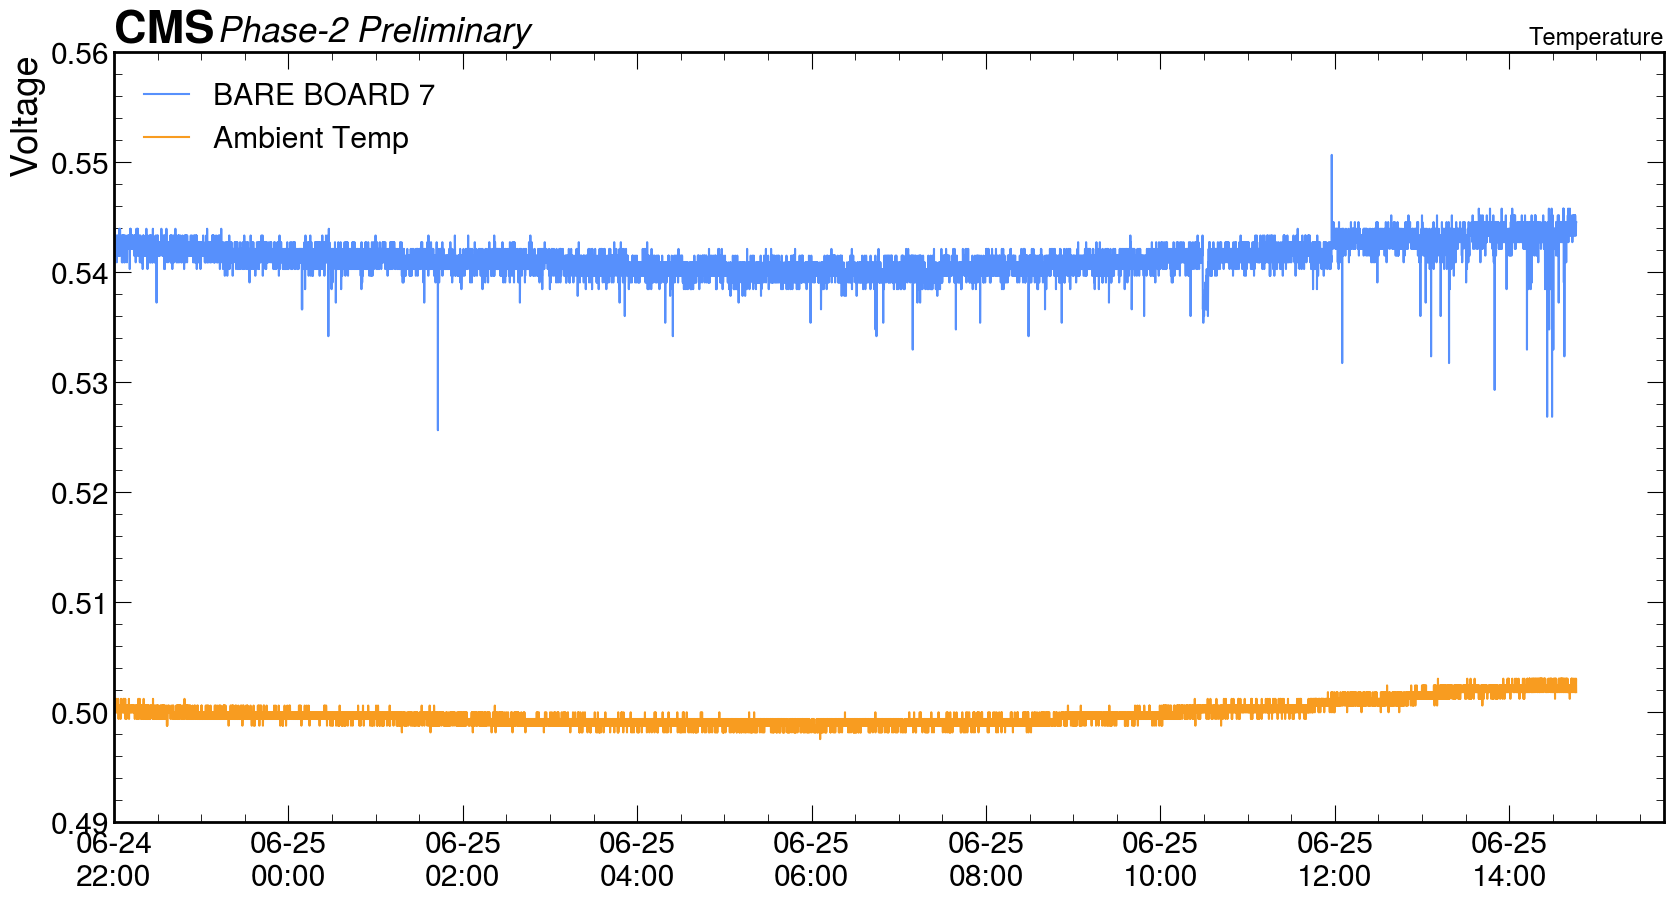

In [59]:
names = ['BARE BOARD 7', 'Ambient Temp']
cut_time = pd.to_datetime('2024-06-24 22:00:00')

fig, ax = plt.subplots(figsize=(20, 10))
hep.cms.text(loc=0, ax=ax, text="Phase-2 Preliminary", fontsize=25)
ax.set_title('Temperature', size=17, loc="right")
date_form = mdates.DateFormatter("%m-%d\n%H:%M")
ax.xaxis.set_major_formatter(date_form)

for idx, iboard in enumerate(sorted(adc_df['channel'].unique())):
    tmp_df = adc_df.loc[adc_df['channel']==iboard]
    ax.plot(tmp_df['timestamp'], tmp_df['voltage'], label=f'{names[idx]}')

text_y = [0.51, 0.55]
# for index, row in run_time_df.iterrows():

#     if index%2 == 0:
#         yval = text_y[0]
#     else:
#         yval = text_y[1]

#     plt.axvline(x=row['Start_Time'], color='magenta', linestyle='dashed')
#     ax.text(x=(row['Start_Time'] - pd.Timedelta(hours=1.2)), y=yval, s=f"Run {row['Run']} Start", rotation=90, va='center', fontsize=12, color='magenta')
#     plt.axvline(x=row['End_Time'], color='black', linestyle='dashdot')
#     ax.text(x=(row['End_Time'] + pd.Timedelta(minutes=15)), y=yval, s=f"Run {row['Run']} End", rotation=90, va='center', fontsize=12)

ax.legend(loc='best')
ax.set_ylabel('Voltage')
plt.ylim(bottom=0.49, top=.56)
plt.xlim(left=cut_time)

# Power Monitoring

In [ ]:
power_directory = output_dir/"PowerPlots"
power_directory.mkdir(exist_ok=True)

with sqlite3.connect(power_file) as sqlite3_connection:
    data_df = pandas.read_sql('SELECT * FROM power_v2', sqlite3_connection, index_col=None)
    data_df['Time'] = pandas.to_datetime(data_df['timestamp'], format='mixed')

    # Remove data that is outside the range of the campaign
    data_df = data_df.loc[data_df['Time'] >= start_time]
    data_df = data_df.loc[data_df['Time'] <= end_time].copy()

    data_df['V'] = data_df['V'].astype(float)
    data_df['I'] = data_df['I'].astype(float)

    print("Timestamps in power database file cover range:")
    print("Min:", data_df['Time'].min())
    print("Max", data_df['Time'].max())

    #print(data_df)

    vref_df = data_df.loc[data_df['Channel'] == 'VRef']
    wsana_df = data_df.loc[data_df['Channel'] == 'WSAnalog']
    wsdig_df = data_df.loc[data_df['Channel'] == 'WSDigital']

## VRef

Plot VRef over time so we can find the range of times where we can be confident the data is ok

In [ ]:
plotVRefPower(vref_df, 'SEU - VRef over Time', power_directory, True)

In [ ]:
# Find time when the SEE happened on the power supply
ps_see_time = vref_df.loc[vref_df["V"] > 0.5]["Time"].max()

print(f'The SEE hapened on the power supply at {ps_see_time}')

## ET2 Bare 5

In [ ]:
board = "ET2.01 Bare Board 5"
plotBoardPower(board, power_connections[board], data_df, f'SEU - {board} Power over Time', power_directory, True)

## Waveform Sampler

In [ ]:
plotWSPower(wsana_df, 'SEU - Waveform Sampler Analog Power over Time', power_directory, True)

In [ ]:
plotWSPower(wsdig_df, 'SEU - Waveform Sampler Digital Power over Time', power_directory, True)

## Per Run Plotting

In [ ]:
run_power_dir = power_directory/"PerRun"
run_power_dir.mkdir(exist_ok=True)

for run_idx_to_plot in range(len(run_info)):
    if run_idx_to_plot == 0:
        makePerRunPlots(
            data_df,
            run_info[run_idx_to_plot],
            run_power_dir,
            power_connections,
            extra_run_info = None,
            test_run_info = test_run_info,
        )
    else:
        makePerRunPlots(
            data_df,
            run_info[run_idx_to_plot],
            run_power_dir,
            power_connections,
            previous_run_info = run_info[run_idx_to_plot - 1],
            extra_run_info = None,
            test_run_info = test_run_info,
        )

# for this_run_info in extra_run_info:
#     makePerRunPlots(
#         data_df,
#         this_run_info,
#         run_power_dir,
#         power_connections,
#         all_run_info = run_info,
#         extra_run_info = extra_run_info,
#         test_run_info = test_run_info,
#     )
